In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

In [126]:
#读取数据

data = pd.read_csv('./data/dataset.csv')
sub = pd.read_csv('./data/submission.csv')

In [128]:
# 以下为rule_based模型分析

**切入切出风速分析**

切入风速是针对并网型风机而言的，是指达到并网条件的风速，也就是可以发电的最低风速，低于此风速会自动停机。

切出风速指风力发电机组并网发电百的最大风速，超过此风速机组将切出电网，就是风机会停机，停止发电，切入速度与叶片的空气动力性能有关。

当达到这个风速时，发电机可以持续稳定的发电，切出风速除度与叶片有关以外还与机组载荷有关，若达到切出风速还不切出，可能会有塔架倒塌，叶轮飞车等事故的风险，启动消耗的电能一般小于切入风速时的发电量


1.需要测试一下，Power和rotorspeed都是0的不一定是异常，因为风速不够不起来是正常的。相反，则可能是异常

2.达到切入风速和超过切出风速，还在转不一定是异常，要看差分，因为开始转和停止转有一个过程的。这里可以看风速和Power历史窗口趋势和rotorspeed的关系

**功率分析**
先对低于0和超过2000的看看有什么发现


**协同分析**
风速变化不大的情况下，转速变化大也是异常

In [129]:
data[data['Power']>2000]

,WindNumber,Time,WindSpeed,Power,RotorSpeed
2526,1,2017/11/21 9:40,12.874500,2089.800000,15.289000
2527,1,2017/11/21 9:50,14.156875,2072.812500,15.258125
2537,1,2017/11/21 13:20,11.593500,2023.200000,15.191000
2538,1,2017/11/21 13:20,11.593500,2023.200000,15.191000
2543,1,2017/11/21 14:10,11.805000,2034.900000,15.203500
...,...,...,...,...,...
497105,12,2019/12/26 21:30,16.925167,2046.501667,15.477500
497106,12,2019/12/26 21:40,16.451000,2046.625000,15.477750
497107,12,2019/12/26 21:50,16.473667,2044.068333,15.460500
497108,12,2019/12/26 22:00,17.568833,2045.656667,15.474500


In [115]:
#这里是直接对RotorSpeed做判断，很粗，要改。

def fun(x):
    if x >16.8 or x<8.33:
        return 1
    else:
        return 0
data['label'] = 0
for i in [1,2,3,4,6,7,8,9,10]:
    temp_values = data.loc[data['WindNumber']==i]['RotorSpeed'].apply(lambda x: fun(x))
    data.loc[data['WindNumber']==i,'label'] = temp_values


def fun_14(x):
    if x >14 or x<5:
        return 1
    else:
        return 0
temp_values = data.loc[data['WindNumber']==11]['RotorSpeed'].apply(lambda x: fun_14(x))
data.loc[data['WindNumber']==11,'label'] = temp_values

def fun_5(x):
    if x >19 or x<5.5:
        return 1
    else:
        return 0
temp_values = data.loc[data['WindNumber']==5]['RotorSpeed'].apply(lambda x: fun_5(x))
data.loc[data['WindNumber']==5,'label'] = temp_values


def fun_12(x):
    if x >17 or x<5.5:
        return 1
    else:
        return 0
temp_values = data.loc[data['WindNumber']==12]['RotorSpeed'].apply(lambda x: fun_12(x))
data.loc[data['WindNumber']==12,'label'] = temp_values

规则模型，最后设置两个fillter，离散度和阈值

In [118]:
sub['label'] = data['label']

sub.to_csv('sub.csv',index=None)

In [ ]:
# 下面是tree_based模型，暂时不管

In [107]:
model_isof = IsolationForest(n_estimators=500)
#尝试一下把windnumber放进去一起，再尝试一下每个windnumber单独做
outlier_label = model_isof.fit_predict(data[['RotorSpeed']])
outlier_pd = pd.DataFrame(outlier_label, columns=['outlier_label'])

data_merge = pd.concat((data, outlier_pd), axis=1)

data_merge['outlier_label'] = data_merge['outlier_label']+2
data_merge['outlier_label'] = data_merge['outlier_label'].astype('str').str.replace('3','0').astype('int')

In [108]:
sub['label'] = data_merge['outlier_label']

sub.to_csv('sub.csv',index=None)

In [ ]:
#baseline:0.39535768257
#只对rotorspeed做树，500:0.41577290285
#增加除法,500,:


In [ ]:
#下面准备做伪标签

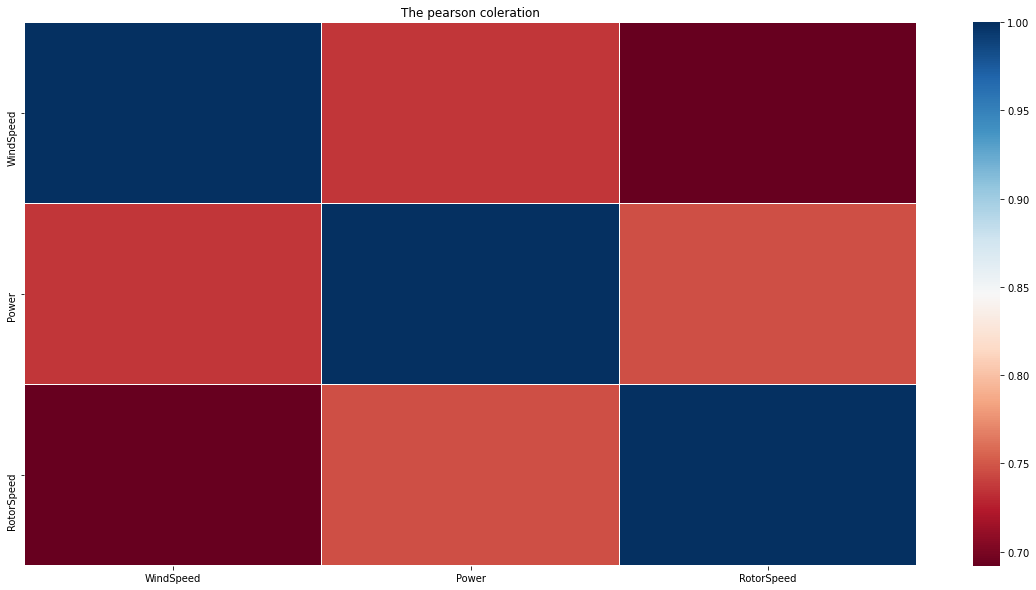

In [130]:
def draw_correlation_heatmap(data: pd.DataFrame, way:str = 'pearson')->None:
    feature = data.copy()
    plt.figure(figsize=(20,10))
    plt.title('The ' + way +' coleration')
    sns.heatmap(feature[[x for x in feature.columns if x not in ['Time','WindNumber'] ]].corr(way),linecolor='white',
        linewidths=0.1,
        cmap="RdBu")
    
draw_correlation_heatmap(data)

In [ ]:
def draw_pointplot(data: pd.DataFrame)->None:
    f, axes = plt.subplots(2, figsize=(12, 10))
    count = 0
    for i in [x for x in data.columns if x not in ['Time','RotorSpeed','WindNumber']]:
        sns.pointplot(x=i, y='RotorSpeed', data=data, ax=axes[count//2],hue='WindNumber')
        count += 1
        
draw_pointplot(data)

In [ ]:
def draw_boxplot(data: pd.DataFrame)->None:
    f, axes = plt.subplots(2, figsize=(12, 10))
    count = 0
    for i in [x for x in data.columns if x not in ['Time','RotorSpeed','WindNumber']]:
        sns.boxenplot(x=i, y='RotorSpeed', data=data, ax=axes[count//2],hue='WindNumber')
        count += 1
        
draw_boxplot(data)